## Подготовка

In [2]:
# Предварительная настройка системы
import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 80)

import datetime
from datetime import datetime, date

import matplotlib.pyplot as plt

## Загрузка

In [4]:
# Настройки загрузки
dir_pickle = '../pickle/'
data_pickle = 'data.pkl'
history_pickle = 'history.pkl'
history_statuses_piclke = 'history_statuses.pkl'
sprints_pickle = 'sprints.pkl'
sprints_tasks_pickle = 'sprints_tasks.pkl'

In [5]:
# Загружаем
dD = pd.read_pickle(f"{dir_pickle}{data_pickle}")
dS = pd.read_pickle(f"{dir_pickle}{sprints_pickle}")
dSE = pd.read_pickle(f"{dir_pickle}{sprints_tasks_pickle}")
dH = pd.read_pickle(f"{dir_pickle}{history_pickle}")
dHS = pd.read_pickle(f"{dir_pickle}{history_statuses_piclke}")
# TODO Неаккуратно настроено, переписать

## Срез по времени • Функция

In [7]:
def slice_by_time(begin, end):
    status_changes_on_sprint = dHS.loc[dHS['history_date'] < end]
    changes_grouped_by_task = status_changes_on_sprint.groupby('entity_id')
    last_changes = changes_grouped_by_task.apply(lambda x: x.nlargest(1, 'history_version'), include_groups=False)
    actual_for_sprint = last_changes.loc[~((last_changes['after'] == 'closed') & (last_changes['history_date'] < begin))]
    return actual_for_sprint

In [8]:
# test_slice = slice_by_time(dS.iloc[1]['sprint_start_date'], dS.iloc[1]['sprint_end_date'])
# test_slice

### Пояснения к реализации функции

In [10]:
# Выбираем спринт
# current_sprint = dS.iloc[1]

In [11]:
# Все изменения статусов в выбранном спринте и раньше
# status_changes_on_sprint = dHS.loc[dHS['history_date'] < current_sprint['sprint_end_date']]

In [12]:
# Группируем по id задачи
# changes_grouped_by_task = status_changes_on_sprint.groupby('entity_id')
# changes_grouped_by_task.size()

In [13]:
# Находим последние записи
# last_changes = changes_grouped_by_task.apply(lambda x: x.nlargest(1, 'history_version'), include_groups=False)
# last_changes

In [14]:
# Выявляем актуальные для спринта
# actual_for_sprint = last_changes.loc[~((last_changes['after'] == 'closed') & (last_changes['history_date'] < current_sprint['sprint_start_date']))]
# actual_for_sprint

## Метрика «К выполнению» • Функция

In [16]:
def todo_metrics(slice_to_count):
    tasks_in_sprint = slice_to_count.loc[slice_to_count['after'] == 'created']
    tasks_list = list(map(lambda x: x[0], list(tasks_in_sprint.index)))
    tasks_data = dD.loc[dD.index.isin(tasks_list)]
    metrics = round(tasks_data['estimation'].sum() / 3600, 1)
    return metrics

In [17]:
# test_todo_metrics = todo_metrics(test_slice)
# test_todo_metrics

### Пояснения к реализации функции 

In [19]:
# Статус категории «Создано»
# created_in_sprint = actual_for_sprint.loc[actual_for_sprint['after'] == 'created']
# created_in_sprint

In [20]:
# Список задач
# todo_list = list(map(lambda x: x[0], list(created_in_sprint.index)))

In [21]:
# Срез для вычисления метрики
# todo_tasks = dD.loc[dD.index.isin(todo_list)]

In [22]:
# metrics_todo = round(todo_tasks['estimation'].sum() / 3600, 1)
# metrics_todo

## Метрика «В работе» • Функция

In [24]:
def inwork_metrics(slice_to_count):
    tasks_in_sprint = slice_to_count.loc[(slice_to_count['after'] != 'done') & (slice_to_count['after'] != 'rejectedByThePerformer')]
    tasks_list = list(map(lambda x: x[0], list(tasks_in_sprint.index)))
    tasks_data = dD.loc[dD.index.isin(tasks_list)]
    metrics = round(tasks_data['estimation'].sum() / 3600, 1)
    return metrics

In [25]:
# test_inwork_metrics = inwork_metrics(test_slice)
# test_inwork_metrics

### Пояснения к реализации функции

In [27]:
# Срез для вычисления метрики
# inwork_in_sprint = actual_for_sprint.loc[(actual_for_sprint['after'] != 'done') & (actual_for_sprint['after'] != 'rejectedByThePerformer')]
# inwork_in_sprint['after'].unique()

In [28]:
# Список задач
# inwork_list = list(map(lambda x: x[0], list(inwork_in_sprint.index)))
# inwork_list

In [29]:
# Задачи в работе
# inwork_tasks = dD.loc[dD.index.isin(inwork_list)]
# inwork_tasks

In [30]:
# Метрика «В работе»
# metrics_inwork = round(inwork_tasks['estimation'].sum() / 3600, 1)
# metrics_inwork

## Метрика «Сделано» • Функция

In [32]:
def done_metrics(slice_to_count):
    tasks_in_sprint = slice_to_count.loc[(slice_to_count['after'] == 'done') | (slice_to_count['after'] == 'closed')]
    tasks_list = list(map(lambda x: x[0], list(tasks_in_sprint.index)))
    tasks_data = dD.loc[dD.index.isin(tasks_list) & (dD['type'] != 'Подзадача')]
    metrics = round(tasks_data['estimation'].sum() / 3600, 1)
    return metrics

In [33]:
# test_done_metrics = done_metrics(test_slice)
# test_done_metrics

In [34]:
# Срез для вычисления метрики
# done_in_sprint = actual_for_sprint.loc[(actual_for_sprint['after'] == 'done') | (actual_for_sprint['after'] == 'closed')]
# done_in_sprint

In [35]:
# Список задач
# done_list = list(map(lambda x: x[0], list(done_in_sprint.index)))
# done_list

In [36]:
# Сделанные задачи
# done_tasks = dD.loc[dD.index.isin(done_list) & (dD['type'] != 'Подзадача')]
# done_tasks

In [37]:
# Метрика «Сделано»
# metrics_done = round(done_tasks['estimation'].sum() / 3600, 1)
# metrics_done

## Диапазон дат в спринте

In [39]:
# Накопительная статистика от даты до даты
def all_data_statistics(begin, end):
    dins = pd.date_range(start=begin, end=end, freq='B')
    ddd = pd.DataFrame({'begin': begin, 'end': dins})
    ddd['slice'] = ddd[['begin', 'end']].apply(lambda row: slice_by_time(row['begin'], row['end']), axis=1)
    ddd['todo'] = ddd['slice'].apply(todo_metrics)
    ddd['inwork'] = ddd['slice'].apply(inwork_metrics)
    ddd['done'] = ddd['slice'].apply(done_metrics)
    ddd.set_index('end', inplace=True)
    # ddd.drop(columns=['slice'], inplace=True)
    return ddd

In [40]:
# Всё ещё спринты по номерам
def all_sprint_statistics(num):
    return all_data_statistics(dS.iloc[num]['sprint_start_date'], dS.iloc[num]['sprint_end_date'])

In [41]:
# test_ddd = all_sprint_statistics(1)
# test_ddd

### Пояснения к реализации функции

In [43]:
# Создаём диапазон дат с шагом в сутки
# Только рабочие дни!
# dins = pd.date_range(start=dS.iloc[2]['sprint_start_date'], end=dS.iloc[2]['sprint_end_date'], freq='B')
#dins

In [44]:
# Считаем срезы
# TODO Заменить на нормальные диапазоны
# ddd = pd.DataFrame({'begin': dS.iloc[2]['sprint_start_date'], 'end': dins})
# ddd['slice'] = ddd[['begin', 'end']].apply(lambda row: slice_by_time(row['begin'], row['end']), axis=1)

In [45]:
# Считаем метрики
# ddd['todo'] = ddd['slice'].apply(todo_metrics)
# ddd['inwork'] = ddd['slice'].apply(inwork_metrics)
# ddd

## Визуализация

In [119]:
# Долго! Надо оптимизировать, конечно
d = list([])
for i in range(1, len(dS) + 1):
    d.append(all_sprint_statistics(i)[['todo', 'inwork', 'done']])

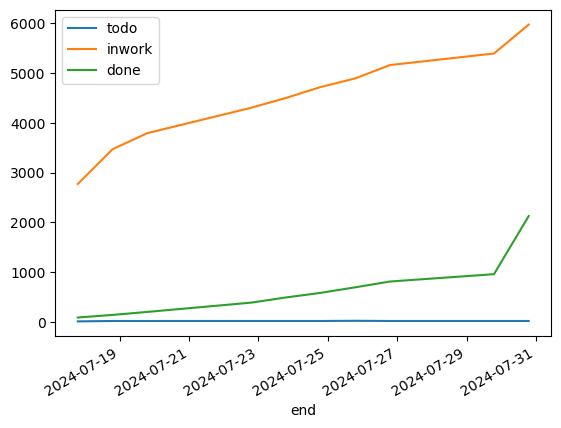

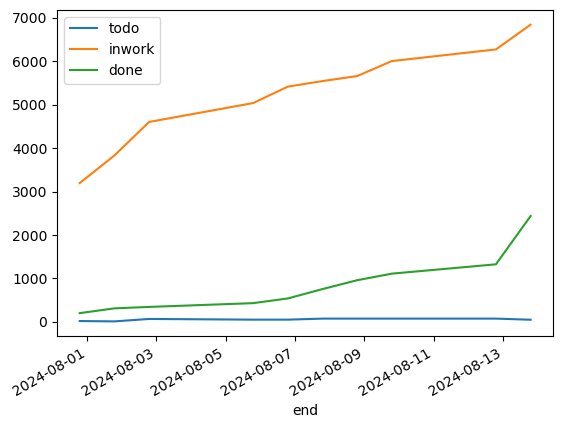

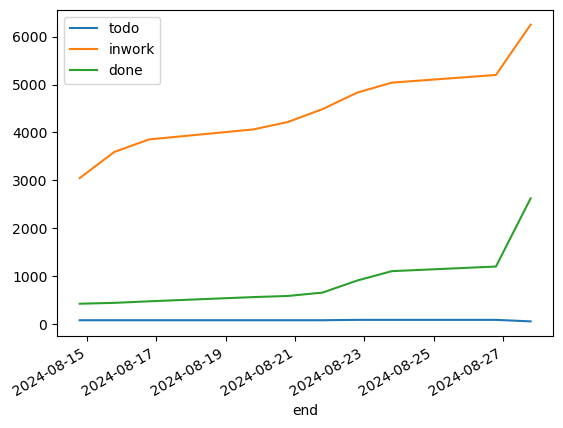

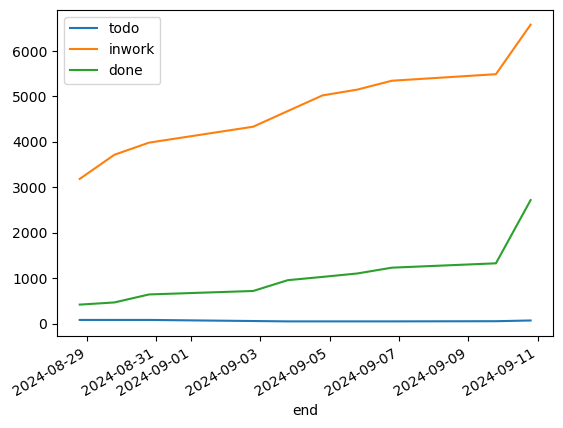

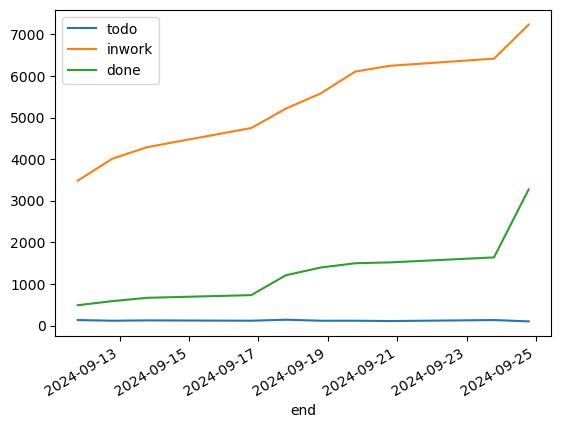

In [133]:
# Рисуем сразу всё
for slice_data in d:
    slice_data.plot()